# MODELO PROBABILISTA: NAÏVE BAYES

In [1]:
import findspark
findspark.init()

import pyspark                                 # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

In [2]:
# Leemos los parquets
train_data = spark.read.parquet("train_spark.parquet")
test_data = spark.read.parquet("test_spark.parquet")

# Mostramos para verificar
print("TRAIN")
train_data.show(1, truncate=True)
print("TEST")
test_data.show(1, truncate=True)

TRAIN
+------------+--------------------+------+--------+-------------+-------+--------+-------------------+-----------------+-----------------+-------------------+-----------------------------+-------------------------+---------------------+----+-------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------------------+------------------------+-----------------+------------------+-------------+-----------------------+----------------------+---------------+-------------------+-------------------+--------------------+---------+---------------------+----------------------+-----------------------+------------------------------+----------------------------------+----------------------------------+-------------------------------+-----------------+
|takeoff_time|           timestamp|  icao|callsign|holding_point| runway|operator|turbulence_category|last_min_takeoffs|last_m

## REPRESENTACIÓN GRÁFICA

 1. Agrupar por callsign y quedarte con el timestamp más reciente

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window

import pyspark.sql.functions as f
from pyspark.sql.window import Window

def get_latest_per_callsign(df):
    """
    Para cada 'callsign', selecciona la fila con el timestamp más reciente.
    """
    # Definir la ventana
    window_spec = Window.partitionBy("callsign").orderBy(f.col("timestamp").desc())
    
    # Añadir columna de número de fila
    df_with_rownum = df.withColumn("row_number", f.row_number().over(window_spec))
    
    # Filtrar la fila más reciente de cada 'callsign'
    latest_per_callsign = df_with_rownum.filter(f.col("row_number") == 1).drop("row_number")
    
    return latest_per_callsign

In [4]:
train_data_graph = get_latest_per_callsign(train_data)
test_data_graph = get_latest_per_callsign(test_data)

2. Histograma y Boxplot (usando takeoff_time como ejemplo de variable respuesta)

Para visualizar estos gráficos, lo más práctico es convertir el resultado a un pandas.DataFrame:

Ahora puedes usar matplotlib o seaborn:

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distribution(df, feature_col):
    """
    Dado un dataframe de Spark, selecciona una columna y genera el histograma y boxplot usando pandas + seaborn.
    """
    # Convertimos a pandas (precaución: solo si no es demasiado grande)
    feature_pd = df.select(feature_col).toPandas()
    
    # Histograma
    plt.figure(figsize=(10, 4))
    sns.histplot(feature_pd[feature_col], bins=30, kde=True)
    plt.title(f"Histograma de {feature_col}")
    plt.xlabel(feature_col)
    plt.ylabel("Frecuencia")
    plt.show()

    # Boxplot
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=feature_pd[feature_col])
    plt.title(f"Boxplot de {feature_col}")
    plt.xlabel(feature_col)
    plt.show()

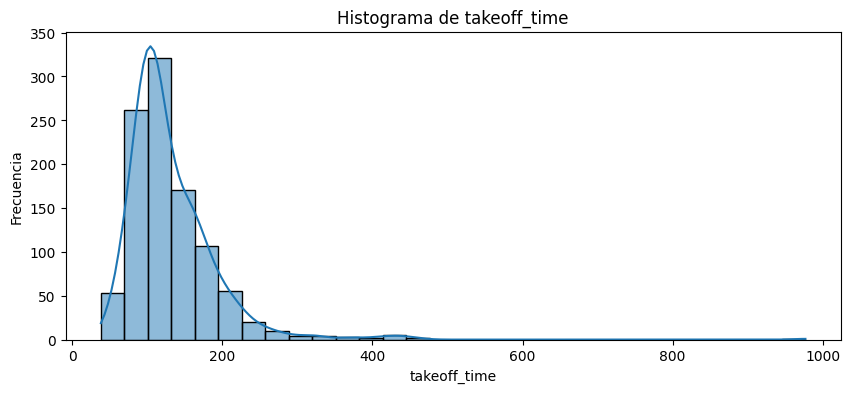

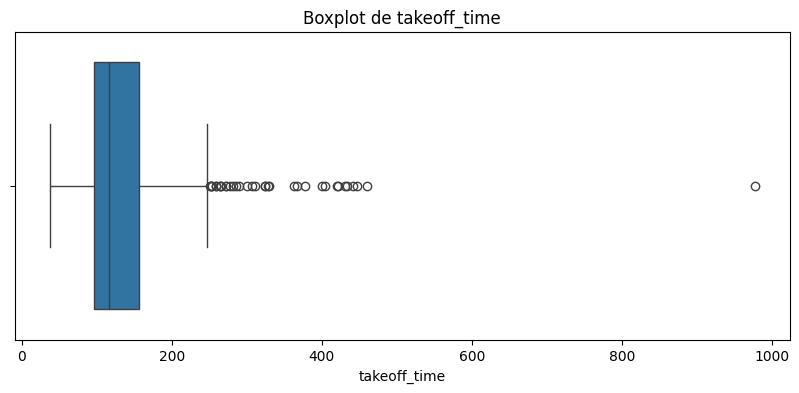

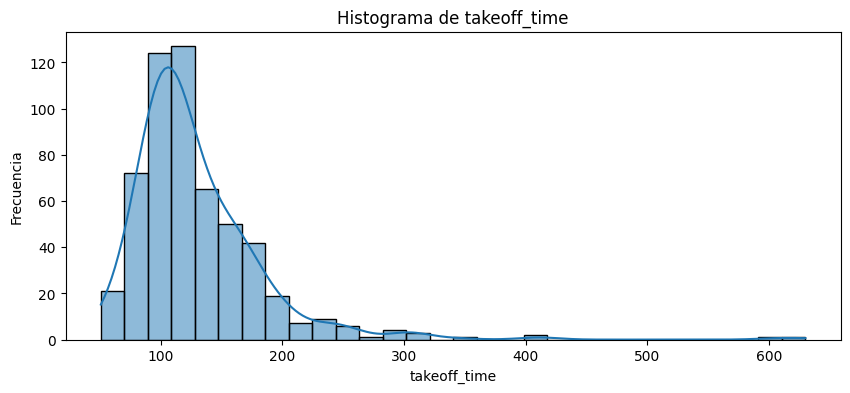

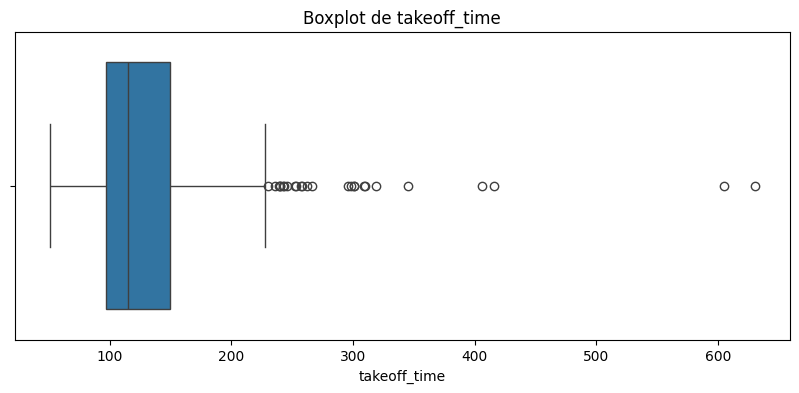

In [6]:
# Graficar la distribución de la variable 'takeoff_time' en train
plot_feature_distribution(train_data_graph, "takeoff_time")

# Si quisieras también graficar en test
plot_feature_distribution(test_data_graph, "takeoff_time")

**¿Qué representa cada barra del histograma?**

Cada barra del histograma te dice cuántos aviones (últimos mensajes) tenían un determinado valor (o rango) de takeoff_time.
Por ejemplo:
- Una barra centrada en 100 te diría que hay varios mensajes cuyo takeoff_time era de 100 segundos antes de despegar.
- Una barra cerca de 0 significa mensajes muy pegados al despegue.

**¿Qué representa este boxplot exactamente?**

El boxplot que estamos generando representa cómo se distribuye el tiempo restante hasta el despegue (takeoff_time, en segundos) justo en el último mensaje de cada callsign.

- Cada punto del boxplot es un avión, representado por su último mensaje antes del despegue.
- El valor en el eje X es el número de segundos que faltaban para el despegue en ese momento (takeoff_time).
- Estás visualizando cómo se agrupan estos tiempos:
    - La caja central muestra el 50% de los vuelos con tiempos más cercanos a la mediana.
    - Las "whiskers" (líneas que salen de la caja) muestran el rango de valores más comunes.
    - Los puntos fuera de las whiskers son potenciales outliers: mensajes enviados muy lejos o muy cerca del despegue comparado con el resto.

## VARIABLE OBJETIVO

Vamos a predecir si un avión ha despegado en el siguiente estado (es decir, si despega o no tras un determinado momento, midámoslo, por ejemplo, en minutos), entonces vamos a necesitar una variable objetivo binaria que indique si el avión despegó o no después de ese instante (después de ese minuto).

De momento, tenemos columnas que puedan aportar pistas, pero no son directamente una variable binaria que haga referencia a lo que queremos predecir.

- 'takeoff_time' ✅ → Esta es la más prometedora, pues indica el tiempo que trascurre desde que llega a un punto de espera hasta que finalmente despega (en segundos).


Entonces, el objetivo es predecir si un avión va a despegar o no en el estado siguiente, por lo que vamos a medir un estado entero como 30 segundos. Es decir, predeciremos si un avión va a despegar o no en los próximos 30 segundos (este dato nos lo da la variable ```takeoff_time```)

La variable objetivo se llamará ```will_takeoff_afterX```, y tomará el valor:
- ```0```: si despegará de 0 a 30 segundos
- ```1```: si despegará de 30 a 60 segundos
- ```2```: si despegará de 60 a 90 segundos
- ```3```: si despegará de 90 a 120 segundos
- ```4```: si despegará de 120 a 150 segundos
- ```5```: si despegará de 150 a 180 segundos
- ```6```: si despegará a partir de los 180 segundos

Por tanto, se trata de una variable categórica multiclase.

La decisión de los 100 segundos se escogió tras un análisis exhaustivo de los datos de los que disponemos actualmente, mostrando el histograma de distribución del tiempo de despegue de los aviones (```takeoff_time```), donde pudimos ver que el valor en el que había más frecuencia de ejemplos era a los 100 segundos, y que esa frecuencia iba menguando hasta los 400 segundos, donde dejó de ser notoria. 

In [7]:
def create_target_variable(df, source_col="takeoff_time", target_col="will_takeoff_afterX"):
    """
    Crea una variable categórica (target) basada en rangos de la columna source_col.
    Los rangos que se crean son:
    - < 30 --> 0
    - < 60 --> 1
    - < 90 --> 2
    - < 120 --> 3
    - < 150 --> 4
    - < 180 --> 5
    - >= 180 --> 6
    """
    df = df.withColumn(target_col,
        f.when(f.col(source_col) < 30, 0)
         .when(f.col(source_col) < 60, 1)
         .when(f.col(source_col) < 90, 2)
         .when(f.col(source_col) < 120, 3)         
         .when(f.col(source_col) < 150, 4)
         .when(f.col(source_col) < 180, 5)
         .otherwise(6)
    )
    return df

In [8]:
# Aplicar sobre train y test
train_data_with_target = create_target_variable(train_data_graph)
test_data_with_target = create_target_variable(test_data_graph)

# Verificar
train_data_with_target.select("takeoff_time", "will_takeoff_afterX").show(5, truncate=False)
test_data_with_target.select("takeoff_time", "will_takeoff_afterX").show(5, truncate=False)

# Contar la distribución de clases
train_data_with_target.groupby("will_takeoff_afterX").count().show()
test_data_with_target.groupby("will_takeoff_afterX").count().show()

+------------+-------------------+
|takeoff_time|will_takeoff_afterX|
+------------+-------------------+
|79.0        |2                  |
|102.0       |3                  |
|88.0        |2                  |
|99.0        |3                  |
|138.0       |4                  |
+------------+-------------------+
only showing top 5 rows

+------------+-------------------+
|takeoff_time|will_takeoff_afterX|
+------------+-------------------+
|71.0        |2                  |
|121.0       |4                  |
|134.0       |4                  |
|125.0       |4                  |
|146.0       |4                  |
+------------+-------------------+
only showing top 5 rows

+-------------------+-----+
|will_takeoff_afterX|count|
+-------------------+-----+
|                  1|   18|
|                  6|  145|
|                  3|  368|
|                  5|  141|
|                  4|  182|
|                  2|  165|
+-------------------+-----+

+-------------------+-----+
|will_takeo

## FEATURE SELECTION


Hay varias columnas que no aportan valor predictivo o que podrían introducir fuga de información (data leakage) si las usamos para predecir si un avión va a despegar en el siguiente instante.

**NOTA**: Este es el análisis teórico de las variables, aunque ya las analizamos prácticamente durante el ejercicio 1 (modelos no probabilistas), donde fueron eliminadas las que debían eliminarse.

**✅ Columnas útiles o potencialmente relevantes:**

Estas columnas sí podrías considerar para el modelo:
- ```'holding_point'```, ```'runway'```, ```'operator'```, ```'turbulence_category'```
- ```'lat'```, ```'lon'``` (posición actual del avión)
- ```'last_min_takeoffs'```, ```'last_min_landings'```, ```'time_since_last_event_seconds'```
- ```'time_before_holding_point'```, ```'time_at_holding_point'```
- ```'hour'```, ```'weekday'```, ```'is_holiday'```
- Condiciones meteorológicas: ```'temperature_2m (°C)'```, ```'rain (mm)'```, ```'wind_speed_10m (km/h)'```, etc.
- ```'is_day ()'```, ```'weather_code (wmo code)'```
- ```'36R_18L'```, ```'32R_14L'```, etc. (si son booleanos indicando pista activa, podrían ser útiles)

------------


**🟡 Columnas dudosas / posiblemente redundantes (pt1):**

- ```'first_holding_time'```: puede reflejar un paso previo al despegue, pero si se genera después del despegue, también sería fuga.
- ```'last_event'```, ```'last_event_turb_cat'```: cuidado, podrían tener fugas si reflejan eventos después del despegue.

**🟡 Columnas dudosas / posiblemente redundantes (pt2):**

- ```'Z1'```, ```'KA6'```, ```'KA8'```, etc.: no está claro qué representan (¿zonas del aeropuerto?). Si son categóricas, podrías mantenerlas si crees que influyen en el comportamiento del avión.

**Recomendaciones basadas en el análisis**:
- Eliminar columnas con frecuencia muy baja (```Z6```, ```LA```, ```LB```, ```KA6```, ```KA8```) si estás preparando datos para un modelo de ML.
- Explorar más profundamente las relaciones entre ```K1```, ```K2```, ```K3```, ```Y1```, y las combinaciones de lados (```36R_18L```, etc.).
- Considerar usar otra métrica para datos booleanos, como correlación de Phi o coeficiente de Jaccard, si te interesa más precisión en variables binarias.
------------------------------
**❌ Columnas que deberíamos quitar del modelo:**

1. Variables que contienen o dependen del futuro: Estas variables contienen el resultado que estamos intentando predecir. Usarlas sería trampa (data leakage).
- ```'takeoff_time'```
- ```'first_airborne_time'```
- ```'first_on_ground_time'```
- ```'event_timestamp'``` (depende del evento registrado, podría estar ya posterior al despegue)
Pero, en cambio, ya las hemos usado para modelar la variable objetivo.

2. Variables que son ID o irrelevantes para el modelo: Estas no aportan información útil para predecir, o son identificadores únicos.
- ```'icao'``` (identificador del avión)
- ```'callsign'``` (también es identificador específico del vuelo)
- ```'timestamp'``` y ```'time'``` (pueden ser redundantes o innecesarios si ya tienes 'hour', 'weekday', etc.)
-------------------

In [9]:
cols_to_drop = [
    'takeoff_time', 'first_airborne_time', 'first_on_ground_time', 'event_timestamp',
    'icao', 'callsign', 'time', 'first_holding_time', '__index_level_0__'
]
# solo quedaría timestamp, que no lo vamos a eliminar porque lo necesitamos para ordenar

train_data_with_target = train_data_with_target.drop(*cols_to_drop)
train_data_with_target.show(1, truncate=False)

test_data_with_target = test_data_with_target.drop(*cols_to_drop)
test_data_with_target.show(1, truncate=False)

+-----------------------+-------------+-------+--------+-------------------+-----------------+-----------------+-------------------+-----------------------------+-------------------------+---------------------+----+-------+----------+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------------------+------------------------+-----------------+------------------+-------------+-----------------------+----------------------+---------------+-------------------+-------------------+--------------------+---------+---------------------+----------------------+-----------------------+------------------------------+----------------------------------+----------------------------------+-------------------------------+-------------------+
|timestamp              |holding_point|runway |operator|turbulence_category|last_min_takeoffs|last_min_landings|last_event_turb_cat|time_since_last_event_se

## VALIDACIÓN

In [10]:
# Obtener la última fecha en train_data_with_target
max_timestamp = train_data_with_target.agg(f.max("timestamp")).collect()[0][0]

print("Última fecha en train_data_with_target:", max_timestamp)

Última fecha en train_data_with_target: 2025-01-14 22:29:16.437000


In [11]:
train_data_with_target.select("timestamp").orderBy("timestamp", ascending=False).show(10, truncate=False)

+-----------------------+
|timestamp              |
+-----------------------+
|2025-01-14 22:29:16.437|
|2025-01-14 19:59:59.993|
|2025-01-14 18:58:51.044|
|2025-01-14 18:23:38.839|
|2025-01-14 18:21:31.786|
|2025-01-14 18:17:57.832|
|2025-01-14 18:12:40.163|
|2025-01-14 16:14:40.099|
|2025-01-14 16:10:58.865|
|2025-01-14 15:59:59.903|
+-----------------------+
only showing top 10 rows



In [12]:
# -- Crear un corte temporal dentro de train_data --
# Por ejemplo, usar como validación el x% más reciente de train_data
# que corresponde a los días 1 a 14 de enero
from pyspark.sql import functions as f

# Definir el rango de validación: del 1 al 14 de enero de 2024
validation_fold = train_data_with_target.filter(
    (f.col("timestamp") >= f.lit("2025-01-01 00:00:00.000000")) & 
    (f.col("timestamp") <= f.lit("2025-01-14 23:59:59.999999"))
)

# El resto para entrenamiento
train_fold = train_data_with_target.filter(
    (f.col("timestamp") < f.lit("2025-01-01 00:00:00.000000"))
)

print(f"Train fold size: {train_fold.count()}, Validation fold size: {validation_fold.count()}")


Train fold size: 509, Validation fold size: 510


## DISEÑO DEL MODELO HIDDEN MARKOV MODEL (HMM)

Hacer lo mismo que Naive Bayes pero con un modelo HMM (Hidden Markov Model) en PySpark no es tan directo porque PySpark no incluye un modelo HMM por defecto como lo hace con Naive Bayes.

Sin embargo, podemos simular algo similar con HMMs en Python (fuera de PySpark) usando ```hmmlearn```, que es la librería más común para esto. Aunque no es distribuido como PySpark, es útil si puedes trabajar con un subconjunto de datos o agrupar secuencias.


Así que después de preparar los datos, haremos:
- Pasarlos a pandas para que HMM pueda leerlos.
- Entrenar un modelo HMM usando ```hmmlearn```.
- Predecir sobre validation y test.
- (Opcional) Loggear en MLflow como hacías con otros modelos.

In [13]:
#pip install hmmlearn

### Consideraciones:

1. La variable a predecir es ```will_takeoff_afterX```.
2. El modelo ```hmmlearn``` solo acepta números reales, así que hay que hacer One-hot Encoding o Label Encoding a las variables categorías. Aunque para HMM (y en general para secuencias) es mejor usar Label Encoding.
3. El HMM espera observaciones como un array X de forma ```(n_samples, n_features)```. Y si queremos usar los datos como secuencia temporal, tenemos que respetar el orden por ```timestamp```.

In [14]:
import pandas as pd

# -- 1. PREPARAR LOS DATOS --
# Primero pasamos de Spark a Pandas
train_pandas = train_fold.orderBy("timestamp").toPandas()
validation_pandas = validation_fold.orderBy("timestamp").toPandas()
test_pandas = test_data_with_target.orderBy("timestamp").toPandas()


# Lista de columnas predictoras
feature_cols = [c for c in train_data_with_target.columns if c not in ["will_takeoff_afterX", 'holding_point', 'runway', 'weekday', 
                                                                       'operator', 'turbulence_category', 'last_event_turb_cat', 'timestamp']]


# -- 1. Prepara los arrays para HMM sin Label Encoding--
X_train = train_pandas[feature_cols].values
y_train = train_pandas["will_takeoff_afterX"].values

X_val = validation_pandas[feature_cols].values
y_val = validation_pandas["will_takeoff_afterX"].values

X_test = test_pandas[feature_cols].values
y_test = test_pandas["will_takeoff_afterX"].values


# Target
target_col = 'will_takeoff_afterX'


# -- 2. APLICAR LABEL ENCODING A LAS COLUMNAS CATEGÓRICAS -- 
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['holding_point', 'runway', 'weekday', 'operator', 'turbulence_category', 'last_event_turb_cat']

label_encoders = {}

# Fit usando todos los datos juntos para evitar clases desconocidas
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_pandas[col], validation_pandas[col], test_pandas[col]]).astype(str))
    
    train_pandas[col] = le.transform(train_pandas[col].astype(str))
    validation_pandas[col] = le.transform(validation_pandas[col].astype(str))
    test_pandas[col] = le.transform(test_pandas[col].astype(str))
    
    label_encoders[col] = le


# -- 3. Prepara los arrays para HMM con Label Encoding--
X_trainL = train_pandas[feature_cols].values
y_trainL = train_pandas["will_takeoff_afterX"].values

X_valL = validation_pandas[feature_cols].values
y_valL = validation_pandas["will_takeoff_afterX"].values

X_testL = test_pandas[feature_cols].values
y_testL = test_pandas["will_takeoff_afterX"].values

In [15]:
# -- 5. ENTRENAR EL MODELO HMM -- 

# Ahora importamos la librería de HMM
from hmmlearn import hmm
import numpy as np

# Definimos el modelo HMM
hmm_model  = hmm.GaussianHMM(
    n_components=5,           # 5 clases (0,1,2,3,4)
    covariance_type="full",   # Cada estado tiene una covarianza completa
    n_iter=100,
    random_state=42
)

# Entrenar el modelo
hmm_model.fit(X_trainL)

GaussianHMM(covariance_type='full', n_components=5, n_iter=100, random_state=42)

In [16]:
# -- 6. PREDECIR SOBRE EL SET DE VALIDACIÓN --
predicted_states = hmm_model.predict(X_valL)


In [17]:
# -- 7. EVALUAR EL MODELO --
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_valL, predicted_states)
print(f"Accuracy en validación temporal: {accuracy:.4f}")

Accuracy en validación temporal: 0.0373


### MEJORANDO EL LABEL ENCODING - AUTOMATIZANDO LA CODIFICACIÓN MANUAL

Vamos a probar a hacer un Label Encoding **manual**, esto es, un **mapping automático**:

En este caso, "mapping automático" se refiere a que, en vez de codificar manualmente las variables categóricas (holding_point, runway, etc.), vamos a convertirlas automáticamente en números usando un Label Encoder para cada columna.

El objetivo es que el HMM (que solo entiende números) pueda trabajar con las variables categóricas codificadas.

In [18]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

def best_state_class_mapping(true_labels, predicted_states):
    cm = confusion_matrix(true_labels, predicted_states)
    
    # Como el assignment minimiza, ponemos los negativos
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    mapping = dict(zip(col_ind, row_ind))
    return mapping

# Creamos el mapping
state_to_class_mapping = best_state_class_mapping(y_val, predicted_states)

# Reasignamos los estados predichos
mapped_predictions = np.array([state_to_class_mapping[state] for state in predicted_states])

# Nuevo Accuracy
new_accuracy = accuracy_score(y_val, mapped_predictions)
print(f"Accuracy después del mappeo: {new_accuracy:.4f}")


Accuracy después del mappeo: 0.3353


## GRIDSEARCH

In [19]:
param_grid = {
    'n_components': [5, 10, 15],  # pruebo 4, 5, 6 estados
    'covariance_type': ['diag', 'full']
}


best_accuracy = 0
best_params = None

for n_components in param_grid['n_components']:
    for covariance_type in param_grid['covariance_type']:
        model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=1000, random_state=42)
        model.fit(X_train)
        
        preds = model.predict(X_val)
        mapping = best_state_class_mapping(y_val, preds)
        
        # Primero obtienes la clase más frecuente en y_val, para asignarla si falta
        most_common_class = np.bincount(y_val).argmax()

        # Ahora haces el mapeo, pero si no existe el estado en el mapping, usas la clase más común
        mapped_preds = np.array([mapping.get(state, most_common_class) for state in preds])

        #mapped_preds = np.array([mapping[state] for state in preds])
        
        acc = accuracy_score(y_val, mapped_preds)
        
        print(f"n_components={n_components}, covariance_type={covariance_type} => Accuracy: {acc:.4f}")
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (n_components, covariance_type)

print("\nMejores parámetros encontrados:")
print(f"n_components = {best_params[0]}, covariance_type = {best_params[1]}")
print(f"Accuracy alcanzado: {best_accuracy:.4f}")


n_components=5, covariance_type=diag => Accuracy: 0.3529


Model is not converging.  Current: -7549.0247515930205 is not greater than -7549.022957429895. Delta is -0.0017941631258509005


n_components=5, covariance_type=full => Accuracy: 0.3353
n_components=10, covariance_type=diag => Accuracy: 0.3235
n_components=10, covariance_type=full => Accuracy: 0.3647
n_components=15, covariance_type=diag => Accuracy: 0.0471


Model is not converging.  Current: 39595.41552578197 is not greater than 39595.41676201011. Delta is -0.0012362281340756454


n_components=15, covariance_type=full => Accuracy: 0.2549

Mejores parámetros encontrados:
n_components = 10, covariance_type = full
Accuracy alcanzado: 0.3647


In [20]:
# Concatenar train + validation
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

# Entrenar el modelo final
final_model = hmm.GaussianHMM(
    n_components=10,
    covariance_type='full',
    random_state=42
)

final_model.fit(X_train_full)

# Predecir en test
preds_test = final_model.predict(X_test)

# Mapping usando TODO el y_train_full
mapping = best_state_class_mapping(y_train_full, final_model.predict(X_train_full))

# Clase más común de y_train_full
most_common_class = np.bincount(y_train_full).argmax()

# Mapear las predicciones
mapped_preds_test = np.array([mapping.get(state, most_common_class) for state in preds_test])

# Calcular accuracy en el test
test_accuracy = accuracy_score(y_test, mapped_preds_test)

print(f"✅ Accuracy en test: {test_accuracy:.4f}")

✅ Accuracy en test: 0.2126


Probemos con más parámetros ahora entonces. Aquí están los disponibles:

| Hiperparámetro      | Descripción                                                                                   |
|---------------------|-----------------------------------------------------------------------------------------------|
| `n_components`       | Número de **estados ocultos** del modelo HMM. Cada estado puede representar una "situación" distinta. |
| `covariance_type`    | Cómo modelar la **covarianza** de las variables dentro de cada estado:<br>- `'diag'`: solo varianzas (más simple).<br>- `'full'`: covarianzas completas (más flexible pero más costoso). |
| `n_iter`             | Número **máximo de iteraciones** del algoritmo EM (Expectation-Maximization) para ajustar el modelo. (Más iteraciones = más oportunidad de converger bien). |
| `tol`                | **Tolerancia** para considerar que el modelo ha **convergido**. Si el cambio en log-likelihood entre iteraciones es menor que `tol`, el entrenamiento se detiene. (Tolerancia pequeña = ajuste más fino). |


In [21]:
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score

param_grid = {
    'n_components': [5, 6, 7, 8],
    'covariance_type': ['diag', 'full'],   # sólo 'diag', no 'full'
    'n_iter': [500],
    'tol': [1e-2, 1e-3]
}


best_accuracy = 0
best_params = None

for n_components in param_grid['n_components']:
    for covariance_type in param_grid['covariance_type']:
        for n_iter in param_grid['n_iter']:
            for tol in param_grid['tol']:
                try:
                    model = hmm.GaussianHMM(
                        n_components=n_components,
                        covariance_type=covariance_type,
                        n_iter=n_iter,
                        tol=tol,
                        random_state=42
                    )
                    model.fit(X_train)
                    
                    preds = model.predict(X_val)

                    # Mapping de estados a clases
                    mapping = best_state_class_mapping(y_val, preds)
                    most_common_class = np.bincount(y_val).argmax()
                    mapped_preds = np.array([mapping.get(state, most_common_class) for state in preds])

                    acc = accuracy_score(y_val, mapped_preds)

                    print(f"n_components={n_components}, covariance_type={covariance_type}, n_iter={n_iter}, tol={tol} => Accuracy: {acc:.4f}")

                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_params = (n_components, covariance_type, n_iter, tol)
                        
                except Exception as e:
                    print(f"Error con n_components={n_components}, covariance_type={covariance_type}, n_iter={n_iter}, tol={tol}: {e}")

print("\n✅ Mejores parámetros encontrados:")
print(f"n_components = {best_params[0]}, covariance_type = {best_params[1]}, n_iter = {best_params[2]}, tol = {best_params[3]}")
print(f"Accuracy alcanzado: {best_accuracy:.4f}")


n_components=5, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3529
n_components=5, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3529
n_components=5, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3353
n_components=5, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3353
n_components=6, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3373
n_components=6, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3373


Model is not converging.  Current: 18714.55987601856 is not greater than 18714.560032693378. Delta is -0.00015667481784475967


n_components=6, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3314


Model is not converging.  Current: 18714.55987601856 is not greater than 18714.560032693378. Delta is -0.00015667481784475967
Model is not converging.  Current: -4887.319168999902 is not greater than -4887.234739049084. Delta is -0.08442995081804838


n_components=6, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3314
n_components=7, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3255


Model is not converging.  Current: -4887.319168999902 is not greater than -4887.234739049084. Delta is -0.08442995081804838


n_components=7, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3255
n_components=7, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3510


Model is not converging.  Current: 23752.00060030544 is not greater than 23752.000600366242. Delta is -6.08015398029238e-08


n_components=7, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3510
n_components=8, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.2784
n_components=8, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.2784
n_components=8, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3039


Model is not converging.  Current: 31507.804997181487 is not greater than 31507.804997310042. Delta is -1.2855525710619986e-07


n_components=8, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3039

✅ Mejores parámetros encontrados:
n_components = 5, covariance_type = diag, n_iter = 500, tol = 0.01
Accuracy alcanzado: 0.3529


In [22]:
# Concatenar train + validation
#X_train_full = np.concatenate([X_train, X_val], axis=0)
#y_train_full = np.concatenate([y_train, y_val], axis=0)

# Entrenar el modelo final
final_model = hmm.GaussianHMM(
    n_components=5,
    covariance_type='diag',
    n_iter=500,
    tol=0.01,
    random_state=42
)

final_model.fit(X_train_full)

# Predecir en test
preds_test = final_model.predict(X_test)

# Mapping usando TODO el y_train_full
mapping = best_state_class_mapping(y_train_full, final_model.predict(X_train_full))

# Clase más común de y_train_full
most_common_class = np.bincount(y_train_full).argmax()

# Mapear las predicciones
mapped_preds_test = np.array([mapping.get(state, most_common_class) for state in preds_test])

# Calcular accuracy en el test
test_accuracy = accuracy_score(y_test, mapped_preds_test)

print(f"✅ Accuracy en test: {test_accuracy:.4f}")


Model is not converging.  Current: -14414.787540907262 is not greater than -14406.108781663657. Delta is -8.678759243604873


✅ Accuracy en test: 0.2829


### Siguientes pasos para investigar por qué cayó el accuracy con el test

In [23]:
# DISTRIBUCIÓN DE CLASES
import pandas as pd

print("Distribución de clases (train_full):")
print(pd.Series(y_train_full).value_counts(normalize=True))

print("\nDistribución de clases (test):")
print(pd.Series(y_test).value_counts(normalize=True))

Distribución de clases (train_full):
3    0.361138
4    0.178606
2    0.161923
6    0.142296
5    0.138371
1    0.017664
Name: proportion, dtype: float64

Distribución de clases (test):
3    0.369369
4    0.212613
2    0.149550
5    0.135135
6    0.115315
1    0.018018
Name: proportion, dtype: float64


In [24]:
# MATRIZ DE CONFUSIÓN DEL TEST
from sklearn.metrics import confusion_matrix, classification_report

print("Matriz de confusión (test):")
print(confusion_matrix(y_test, mapped_preds_test))

print("\nClassification Report (test):")
print(classification_report(y_test, mapped_preds_test))


Matriz de confusión (test):
[[  0   5   5   0   0   0]
 [  0  20  47  16   0   0]
 [  0  33 119  52   0   1]
 [  0  19  82  17   0   0]
 [  0  11  48  15   0   1]
 [  0  16  31  16   0   1]]

Classification Report (test):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.19      0.24      0.21        83
           3       0.36      0.58      0.44       205
           4       0.15      0.14      0.15       118
           5       0.00      0.00      0.00        75
           6       0.33      0.02      0.03        64

    accuracy                           0.28       555
   macro avg       0.17      0.16      0.14       555
weighted avg       0.23      0.28      0.23       555



C:\Users\chase\PycharmProjects\TDDProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chase\PycharmProjects\TDDProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chase\PycharmProjects\TDDProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

El problem es que las clases están MUY desbalanceadas: tenemos MUCHOS ejemplos de clase 1, y muy poquitos de clases 2, 3 y 4. Eso hace que el modelo tienda a predecir siempre la clase 1 (lo vimos en la matriz de confusión).

Hay dos formas principales:


|Método|	Idea|	Cómo aplicarlo aquí |
| --- | ----| ---|
|Undersampling|	Quitar ejemplos de la clase mayoritaria (por ejemplo, quitar parte de los datos de clase 1).	|Podrías reducir los ejemplos de clase 1 en el train_full.|
|Oversampling	|Aumentar ejemplos de clases minoritarias (por ejemplo, duplicar registros de clase 2, 3, 4 y 5).	Podrías duplicar o triplicar los datos de las clases 2, 3, 4 y 5.|

Lo recomendable en nuestro caso es hacer oversampling, porque hay muy poquitos datos de las clases 3 y 4 (¡sólo 6 ejemplos de la clase 3 en test!), y tampoco queremos perder info de las clases importantes.

Primero, balancearemos el X_train y probaremos con el X_val (Pero NO debemos balancear X_val, porque necesitamos que la validación represente el mundo real (que tiene desbalance).

In [25]:
# BALANCEAR X_TRAIN
from sklearn.utils import resample
import pandas as pd

# Unir X_full_train y y_full_train en un DataFrame para trabajar
train_data = pd.DataFrame(X_train)
train_data['will_takeoff_afterX'] = y_train

# Separar por clases
class_0 = train_data[train_data['will_takeoff_afterX'] == 0]
class_1 = train_data[train_data['will_takeoff_afterX'] == 1]
class_2 = train_data[train_data['will_takeoff_afterX'] == 2]
class_3 = train_data[train_data['will_takeoff_afterX'] == 3]
class_4 = train_data[train_data['will_takeoff_afterX'] == 4]
class_5 = train_data[train_data['will_takeoff_afterX'] == 5]
class_6 = train_data[train_data['will_takeoff_afterX'] == 6]


# Obtener el tamaño de la clase mayoritaria (clase 3)
majority_class_size = len(class_3)

# Oversample todas las clases minoritarias a ese tamaño
class_1_oversampled = resample(class_1, replace=True, n_samples=majority_class_size, random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=majority_class_size, random_state=42)
class_4_oversampled = resample(class_4, replace=True, n_samples=majority_class_size, random_state=42)
class_5_oversampled = resample(class_5, replace=True, n_samples=majority_class_size, random_state=42)
class_6_oversampled = resample(class_6, replace=True, n_samples=majority_class_size, random_state=42)

# La clase 0 y la clase 3 no se deben oversamplear, ya que son las clases más representadas
class_0_oversampled = class_0  # Clase 0 no se sobresamplea
class_3_oversampled = class_3  # Clase 3 no se sobresamplea

# Juntar todas las clases balanceadas
train_data_balanced = pd.concat([class_0_oversampled, class_1_oversampled, class_2_oversampled, class_3_oversampled, class_4_oversampled, class_5_oversampled, class_6_oversampled])

# Separar de nuevo X e y
X_train_balanced = train_data_balanced.drop(columns=['will_takeoff_afterX']).values
y_train_balanced = train_data_balanced['will_takeoff_afterX'].values


In [26]:
best_accuracy = 0
best_params = None

param_grid = {
    'n_components': [4, 5, 6, 7, 8], 
    'covariance_type': ['diag', 'full'],
    'n_iter': [100, 200, 500],
    'tol': [1e-2, 1e-3]
}

for n_components in param_grid['n_components']:
    for covariance_type in param_grid['covariance_type']:
        for n_iter in param_grid['n_iter']:
            for tol in param_grid['tol']:
                
                model = hmm.GaussianHMM(
                    n_components=n_components,
                    covariance_type=covariance_type,
                    n_iter=n_iter,
                    tol=tol,
                    random_state=42
                )
                model.fit(X_train_balanced)
                
                preds = model.predict(X_val)
                mapping = best_state_class_mapping(y_val, preds)

                most_common_class = np.bincount(y_val).argmax()
                mapped_preds = np.array([mapping.get(state, most_common_class) for state in preds])

                acc = accuracy_score(y_val, mapped_preds)
                
                print(f"n_components={n_components}, covariance_type={covariance_type}, n_iter={n_iter}, tol={tol} => Accuracy: {acc:.4f}")
                
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_params = (n_components, covariance_type, n_iter, tol)

print("\n✅ Mejores parámetros encontrados tras el balanceo:")
print(f"n_components = {best_params[0]}, covariance_type = {best_params[1]}, n_iter = {best_params[2]}, tol = {best_params[3]}")
print(f"Accuracy alcanzado en val: {best_accuracy:.4f}")

n_components=4, covariance_type=diag, n_iter=100, tol=0.01 => Accuracy: 0.3471
n_components=4, covariance_type=diag, n_iter=100, tol=0.001 => Accuracy: 0.3471
n_components=4, covariance_type=diag, n_iter=200, tol=0.01 => Accuracy: 0.3471
n_components=4, covariance_type=diag, n_iter=200, tol=0.001 => Accuracy: 0.3471
n_components=4, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3471
n_components=4, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3471
n_components=4, covariance_type=full, n_iter=100, tol=0.01 => Accuracy: 0.2961
n_components=4, covariance_type=full, n_iter=100, tol=0.001 => Accuracy: 0.2961
n_components=4, covariance_type=full, n_iter=200, tol=0.01 => Accuracy: 0.2961
n_components=4, covariance_type=full, n_iter=200, tol=0.001 => Accuracy: 0.2961
n_components=4, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.2961
n_components=4, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.2961
n_components=5, covariance_type=diag, n_iter=1

Model is not converging.  Current: 979.1496451177989 is not greater than 979.1629879928395. Delta is -0.013342875040621038


n_components=5, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3667


Model is not converging.  Current: 979.1496451177989 is not greater than 979.1629879928395. Delta is -0.013342875040621038


n_components=6, covariance_type=diag, n_iter=100, tol=0.01 => Accuracy: 0.3431
n_components=6, covariance_type=diag, n_iter=100, tol=0.001 => Accuracy: 0.3431


Model is not converging.  Current: 979.1496451177989 is not greater than 979.1629879928395. Delta is -0.013342875040621038
Model is not converging.  Current: 979.1496451177989 is not greater than 979.1629879928395. Delta is -0.013342875040621038


n_components=6, covariance_type=diag, n_iter=200, tol=0.01 => Accuracy: 0.3431


Model is not converging.  Current: 979.1496451178105 is not greater than 979.1629879928838. Delta is -0.013342875073362848


n_components=6, covariance_type=diag, n_iter=200, tol=0.001 => Accuracy: 0.3431
n_components=6, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3431


Model is not converging.  Current: 979.1496451177989 is not greater than 979.1629879928395. Delta is -0.013342875040621038


n_components=6, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3431
n_components=6, covariance_type=full, n_iter=100, tol=0.01 => Accuracy: 0.3059
n_components=6, covariance_type=full, n_iter=100, tol=0.001 => Accuracy: 0.3059
n_components=6, covariance_type=full, n_iter=200, tol=0.01 => Accuracy: 0.3059
n_components=6, covariance_type=full, n_iter=200, tol=0.001 => Accuracy: 0.3059
n_components=6, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3059
n_components=6, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3059


Model is not converging.  Current: -3357.3049917386224 is not greater than -3352.9875877842483. Delta is -4.317403954374186


n_components=7, covariance_type=diag, n_iter=100, tol=0.01 => Accuracy: 0.3353


Model is not converging.  Current: -3357.3049917386224 is not greater than -3352.9875877842483. Delta is -4.317403954374186


n_components=7, covariance_type=diag, n_iter=100, tol=0.001 => Accuracy: 0.3353


Model is not converging.  Current: -3357.304991738677 is not greater than -3352.9875877847608. Delta is -4.317403953916255


n_components=7, covariance_type=diag, n_iter=200, tol=0.01 => Accuracy: 0.3353


Model is not converging.  Current: -3357.304991738677 is not greater than -3352.9875877847608. Delta is -4.317403953916255


n_components=7, covariance_type=diag, n_iter=200, tol=0.001 => Accuracy: 0.3353


Model is not converging.  Current: -3357.304991738677 is not greater than -3352.9875877847608. Delta is -4.317403953916255


n_components=7, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3353


Model is not converging.  Current: -3357.304991738677 is not greater than -3352.9875877847608. Delta is -4.317403953916255


n_components=7, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3353
n_components=7, covariance_type=full, n_iter=100, tol=0.01 => Accuracy: 0.3039
n_components=7, covariance_type=full, n_iter=100, tol=0.001 => Accuracy: 0.3039
n_components=7, covariance_type=full, n_iter=200, tol=0.01 => Accuracy: 0.3039
n_components=7, covariance_type=full, n_iter=200, tol=0.001 => Accuracy: 0.3039
n_components=7, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3039


Model is not converging.  Current: -8930.572913363261 is not greater than -8929.665337121121. Delta is -0.9075762421398395


n_components=7, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3039
n_components=8, covariance_type=diag, n_iter=100, tol=0.01 => Accuracy: 0.3529


Model is not converging.  Current: -8930.572913363694 is not greater than -8929.665337121469. Delta is -0.907576242225332
Model is not converging.  Current: -8930.572913363694 is not greater than -8929.665337121469. Delta is -0.907576242225332


n_components=8, covariance_type=diag, n_iter=100, tol=0.001 => Accuracy: 0.3529
n_components=8, covariance_type=diag, n_iter=200, tol=0.01 => Accuracy: 0.3529


Model is not converging.  Current: -8930.572913363261 is not greater than -8929.665337121121. Delta is -0.9075762421398395
Model is not converging.  Current: -8930.572913363065 is not greater than -8929.665337121138. Delta is -0.9075762419270177


n_components=8, covariance_type=diag, n_iter=200, tol=0.001 => Accuracy: 0.3529
n_components=8, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.3529


Model is not converging.  Current: -8930.572913363065 is not greater than -8929.665337121138. Delta is -0.9075762419270177


n_components=8, covariance_type=diag, n_iter=500, tol=0.001 => Accuracy: 0.3529
n_components=8, covariance_type=full, n_iter=100, tol=0.01 => Accuracy: 0.3333
n_components=8, covariance_type=full, n_iter=100, tol=0.001 => Accuracy: 0.3333
n_components=8, covariance_type=full, n_iter=200, tol=0.01 => Accuracy: 0.3333
n_components=8, covariance_type=full, n_iter=200, tol=0.001 => Accuracy: 0.3333
n_components=8, covariance_type=full, n_iter=500, tol=0.01 => Accuracy: 0.3333
n_components=8, covariance_type=full, n_iter=500, tol=0.001 => Accuracy: 0.3333
n_components=9, covariance_type=diag, n_iter=100, tol=0.01 => Accuracy: 0.2647
n_components=9, covariance_type=diag, n_iter=100, tol=0.001 => Accuracy: 0.2647
n_components=9, covariance_type=diag, n_iter=200, tol=0.01 => Accuracy: 0.2647
n_components=9, covariance_type=diag, n_iter=200, tol=0.001 => Accuracy: 0.2647
n_components=9, covariance_type=diag, n_iter=500, tol=0.01 => Accuracy: 0.2647
n_components=9, covariance_type=diag, n_iter=5

In [29]:
# Concatenar train balanceado + validation
X_train_full_balanced = np.concatenate([X_train_balanced, X_val], axis=0)
y_train_full_balanced = np.concatenate([y_train_balanced, y_val], axis=0)

# Entrenar el modelo final
final_model = hmm.GaussianHMM(
    n_components=5,
    covariance_type='full',
    n_iter=100,
    tol=0.01,
    random_state=42
)

final_model.fit(X_train_full_balanced)

# Predecir en test
preds_test = final_model.predict(X_test)

# Mapping usando TODO el y_train_full
mapping = best_state_class_mapping(y_train_full_balanced, final_model.predict(X_train_full_balanced))

# Clase más común de y_train_full
most_common_class = np.bincount(y_train_full_balanced).argmax()

# Mapear las predicciones
mapped_preds_test = np.array([mapping.get(state, most_common_class) for state in preds_test])

# Calcular accuracy en el test
test_accuracy = accuracy_score(y_test, mapped_preds_test)

print(f"✅ Accuracy en test: {test_accuracy:.4f}")


✅ Accuracy en test: 0.2883


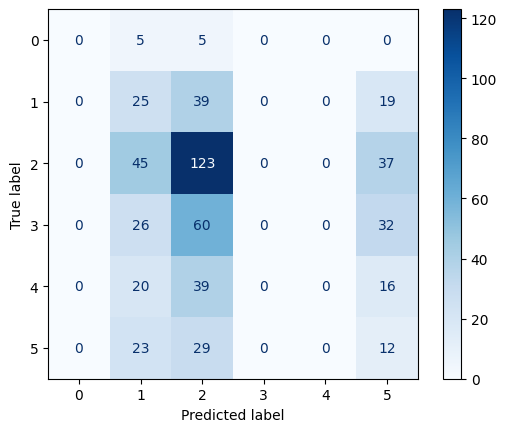

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(y_test, mapped_preds_test)

# Mostrar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
